# FER - Facial Emotions Recognition

This notebook contains an image classifier.

# 1. Problem

# 2. Data
FER - Facial Emotion Recognition https://www.kaggle.com/datasets/msambare/fer2013
# 3. Evaluation

# 4. Features

# Imports Explanation:
* numpy: For numerical operations and array handling.
* matplotlib.pyplot & seaborn: For plotting graphs and visualizations.
* cuml.svm.SVC as cuSVC: GPU-accelerated Support Vector Classifier from RAPIDS.
* cuml.preprocessing.StandardScaler as cuStandardScaler: GPU-based feature scaling.
* cuml.metrics.accuracy_score as cu_accuracy: GPU version of accuracy calculation.
* sklearn.metrics.classification_report & confusion_matrix: Evaluate classification performance.
* cv2: OpenCV library for image processing.
* skimage.feature.hog: Extract Histogram of Oriented Gradients features from images.
* os: Handle file paths and directories.
* kagglehub: Interface for downloading and managing Kaggle datasets.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.svm import SVC as cuSVC
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.metrics import accuracy_score as cu_accuracy
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from skimage.feature import hog
import os
import kagglehub

**GPU HOG (OpenCV CUDA)**

This function extracts HOG (Histogram of Oriented Gradients) features from images using the CPU. It converts each image into a feature vector that can be used for machine learning models.

In [ ]:
def extract_hog_cpu(images):
    print("\n[CPU] Extracting HOG features...")

    features = []
    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"  Processed {i}/{len(images)}")

        f = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        features.append(f)

    features = np.array(features)
    print(f"[CPU] HOG shape: {features.shape}")
    return features

**LOAD IMAGES**

This function loads grayscale images from emotion-labeled folders, resizes them to 48×48 pixels, and assigns numeric labels for each emotion. It returns arrays of images and their corresponding labels.

In [ ]:
def load_images(folder_path):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    images, labels = [], []

    print(f"\nLoading images from {folder_path}...")

    for emotion_idx, emotion in enumerate(emotions):
        emotion_folder = os.path.join(folder_path, emotion)
        if not os.path.exists(emotion_folder):
            continue

        for filename in os.listdir(emotion_folder):
            if filename.endswith((".jpg", ".png", ".jpeg")):
                img = cv2.imread(os.path.join(emotion_folder, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    labels.append(emotion_idx)

        print(f"  {emotion}: {sum(1 for l in labels if l == emotion_idx)} images")

    return np.array(images), np.array(labels)

**PREPROCESS**

This function normalizes image pixel values to the range [0, 1] for better model performance.

In [ ]:
def preprocess_images(images):
    return images / 255.0

**TRAIN GPU SVM**

This function trains a Support Vector Machine (SVM) on the GPU using cuML. First, it scales the input features to standardize them, which improves SVM performance. Then, it fits an RBF-kernel SVM to the training data, allowing the model to learn to classify different emotions efficiently using GPU acceleration. The function returns both the trained model and the scaler for future preprocessing.

In [ ]:
def train_model_gpu(X_train, y_train):
    print("\n Training cuML SVM on T4...")

    scaler = cuStandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = cuSVC(kernel='rbf', C=1.0)
    model.fit(X_train_scaled, y_train)

    print("[GPU] Training complete!")
    return model, scaler

**TEST GPU MODEL**

This function evaluates the trained GPU SVM by scaling the test features, making predictions, and calculating accuracy. It returns the predicted labels and accuracy score.

In [ ]:
def test_model_gpu(model, scaler, X_test, y_test):
    print("\n Testing model...")

    X_test_scaled = scaler.transform(X_test)
    preds = model.predict(X_test_scaled)

    acc = float(cu_accuracy(y_test, preds))

    print(f"[GPU] Accuracy: {acc*100:.2f}%")
    return np.array(preds), acc

**RESULTS (CPU PLOTS)**

This function prints a detailed classification report and visualizes the confusion matrix using a heatmap, showing how well the model predicted each emotion.

In [ ]:
def show_results(y_test, predictions):
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

    print("\nDetailed classification report:")
    print(classification_report(y_test, predictions, target_names=emotions))

    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=emotions, yticklabels=emotions)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Using Colab cache for faster access to the 'fer2013' dataset.

Loading images from /kaggle/input/fer2013/train...
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Loading images from /kaggle/input/fer2013/test...
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images

[CPU] Extracting HOG features...
  Processed 0/28709
  Processed 500/28709
  Processed 1000/28709
  Processed 1500/28709
  Processed 2000/28709
  Processed 2500/28709
  Processed 3000/28709
  Processed 3500/28709
  Processed 4000/28709
  Processed 4500/28709
  Processed 5000/28709
  Processed 5500/28709
  Processed 6000/28709
  Processed 6500/28709
  Processed 7000/28709
  Processed 7500/28709
  Processed 8000/28709
  Processed 8500/28709
  Processed 9000/28709
  Processed 9500/28709
  Processed 10000/28709
  Processed 10500/28709

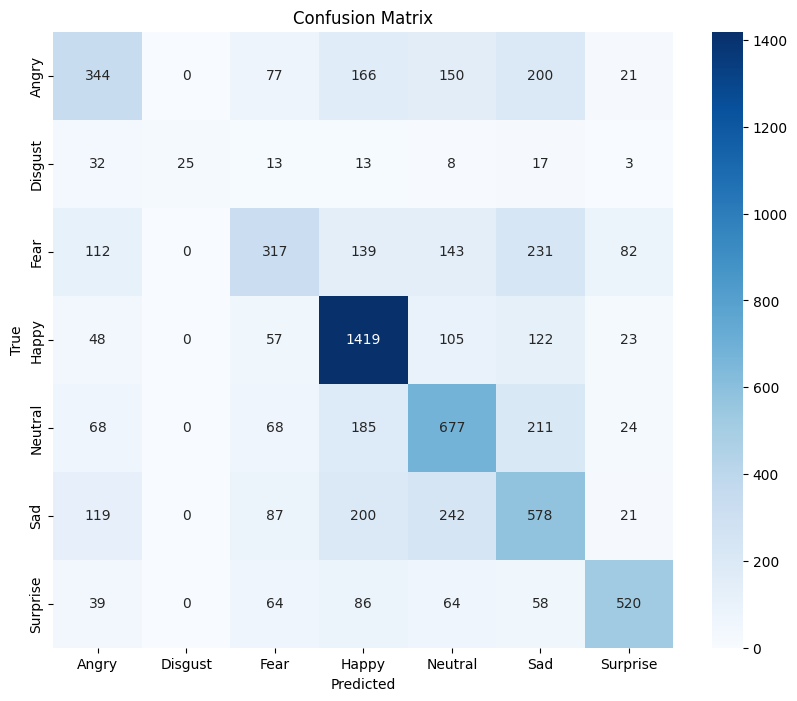

In [ ]:
def main():

    dataset_path = kagglehub.dataset_download("msambare/fer2013")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")

    train_images, train_labels = load_images(train_path)
    test_images, test_labels = load_images(test_path)

    train_images = preprocess_images(train_images)
    test_images = preprocess_images(test_images)

    X_train = extract_hog_cpu(train_images)
    X_test = extract_hog_cpu(test_images)


    model, scaler = train_model_gpu(X_train, train_labels)
    preds, acc = test_model_gpu(model, scaler, X_test, test_labels)

    show_results(test_labels, preds)


if __name__ == "__main__":
    main()
